# Agent Based Modelling

In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.datacollection import DataCollector

import numpy as np
from numpy import random

max_playrate = 20
experience_factor = 100


def win_probability(elo_difference):
    proba = 1 / (1 + 10 ** (-elo_difference / 400))
    return proba


def elo_change(elo_difference, K=14):
    return K * (1 - win_probability(elo_difference))


def pick_elo():
    """
    Generate a random elo value from a distribution that mimicks the distribution of chess elo scores on Lichess Blitz.
    """
    return min(
        1200 + (1500 / 14) * np.abs(51 - random.binomial(100, 0.5)), 2700
    ) - random.randint(100)


class GwentAgent(Agent):
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.peak_mmr = 2400
        self.current_mmr = 2400
        self.games_played = 0
        self.wins = 0

        # self.elo_level = random.randint(1200, 2700)
        self.elo_level = pick_elo()
        self.playrate = random.randint(1, max_playrate)

    @property
    def win_rate(self):
        if self.games_played > 0:
            return (self.wins * 100) / self.games_played
        return None

    @property
    def elo_experience(self):
        """
        Take the ELO increased with an experience score based on the number of games played and the experience factor.
        """
        return self.elo_level + np.sqrt(self.games_played) * experience_factor

    def win(self, other_player):
        mmr_change = elo_change(self.current_mmr - other_player.current_mmr)
        self.current_mmr += mmr_change
        self.peak_mmr = max(self.current_mmr, self.peak_mmr)
        self.games_played += 1
        self.wins += 1

    def loss(self, other_player):
        mmr_change = elo_change(other_player.current_mmr - self.current_mmr)
        self.current_mmr -= mmr_change
        self.games_played += 1

    def find_opponent(self, min_number=20):
        """
        Pick a random other agent to play against. This agent should have a comparable current mmr. So we will grow the mmr 
        range until there are at least
        """
        mmr_range = 10

        while (
            len(
                [
                    a
                    for a in self.model.schedule.agents
                    if a.unique_id != self.unique_id
                    and abs(self.current_mmr - a.current_mmr) <= mmr_range
                ]
            )
            < min_number
        ):
            mmr_range += 7

        possible_opponents = [
            a
            for a in self.model.schedule.agents
            if a.unique_id != self.unique_id
            and abs(self.current_mmr - a.current_mmr) <= mmr_range
        ]

        opponent = random.choice(
            [a for a in possible_opponents],
            1,
            [a.playrate for a in possible_opponents],
        )[0]

        return opponent

    def play_against(self, other_agent):
        # Calculate win probability, check if player won, adjust scores accordingly
        wp = win_probability(self.elo_experience - other_agent.elo_experience)
        rp = random.random()
        won = rp < wp

        if won:
            self.win(other_agent)
            other_agent.loss(self)
        else:
            other_agent.win(self)
            self.loss(other_agent)

    def step(self):
        # Check if this agent will play a round
        rp = random.randint(max_playrate + 1)
        if rp >= self.playrate:
            return

        # Find an opponent
        other_agent = self.find_opponent()

        # Play against opponent and adjust score
        self.play_against(other_agent)


class GwentModel(Model):
    def __init__(self, N):
        self.num_agents = N
        self.schedule = RandomActivation(self)

        for i in range(self.num_agents):
            a = GwentAgent(i, self)
            self.schedule.add(a)

            self.datacollector = DataCollector(
                agent_reporters={
                    "Peak MMR": "peak_mmr",
                    "Current MMR": "current_mmr",
                    "Win Rate": "win_rate",
                    "Games Played": "games_played",
                    "Games Won": "wins",
                    "elo": "elo_level",
                    "elo_xp": "elo_experience",
                }
            )

    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()

<IPython.core.display.Javascript object>

In [3]:
from tqdm import tqdm

model = GwentModel(8000)
for i in tqdm(range(100)):
    model.step()

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [29:05<00:00, 17.46s/it]


<IPython.core.display.Javascript object>

In [4]:
import pickle
import gzip
import os

if not os.path.exists('data'):
    os.makedirs('data')
if not os.path.exists('images'):
    os.makedirs('images')
    
with gzip.GzipFile(f"./data/model_experience_factor_{experience_factor}.gz", 'wb') as file:
    file.write(pickle.dumps(model))


<IPython.core.display.Javascript object>

In [5]:
time_df = model.datacollector.get_agent_vars_dataframe()
time_df.to_csv(f"./data/simulation_steps_experience_factor_{experience_factor}.csv")
time_df.head()

Peak MMR  Current MMR  Win Rate  Games Played  Games Won  \
Step AgentID                                                             
0    0          2400.0       2400.0       NaN             0          0   
     1          2400.0       2400.0       NaN             0          0   
     2          2400.0       2400.0       NaN             0          0   
     3          2400.0       2400.0       NaN             0          0   
     4          2400.0       2400.0       NaN             0          0   

                      elo       elo_xp  
Step AgentID                            
0    0        1341.285714  1341.285714  
     1        1656.714286  1656.714286  
     2        1625.571429  1625.571429  
     3        1329.285714  1329.285714  
     4        1718.714286  1718.714286

<IPython.core.display.Javascript object>

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

plt.rcParams["figure.figsize"] = [15, 5]

<IPython.core.display.Javascript object>

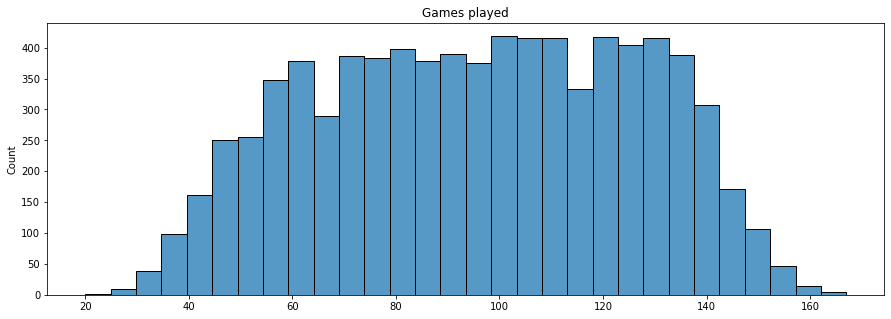

<IPython.core.display.Javascript object>

In [7]:
sns.histplot([agent.games_played for agent in model.schedule.agents]).set_title(
    "Games played"
)
plt.show()

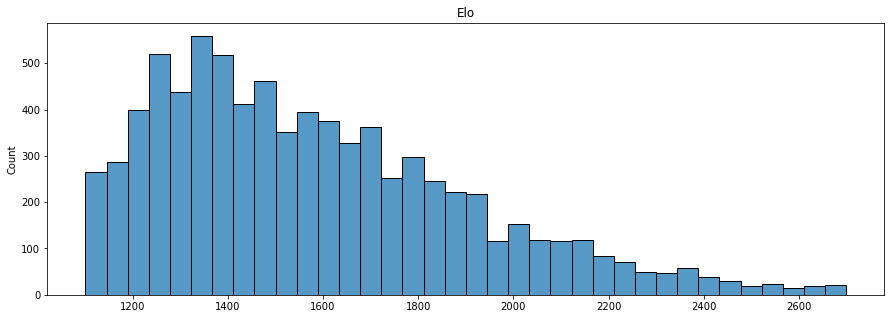

<IPython.core.display.Javascript object>

In [8]:
sns.histplot([agent.elo_level for agent in model.schedule.agents]).set_title("Elo")
plt.show()

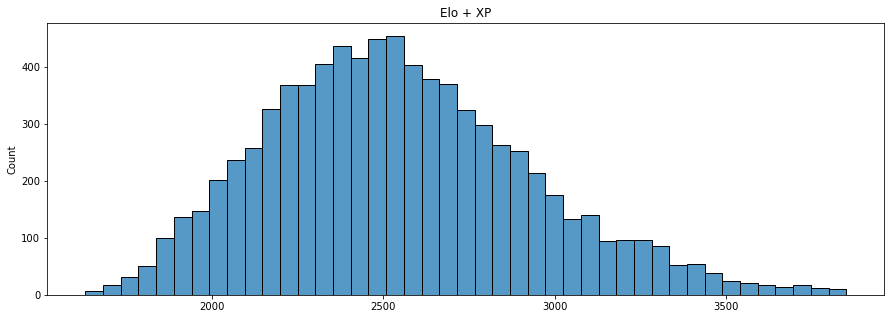

<IPython.core.display.Javascript object>

In [9]:
sns.histplot([agent.elo_experience for agent in model.schedule.agents]).set_title(
    "Elo + XP"
)
plt.show()

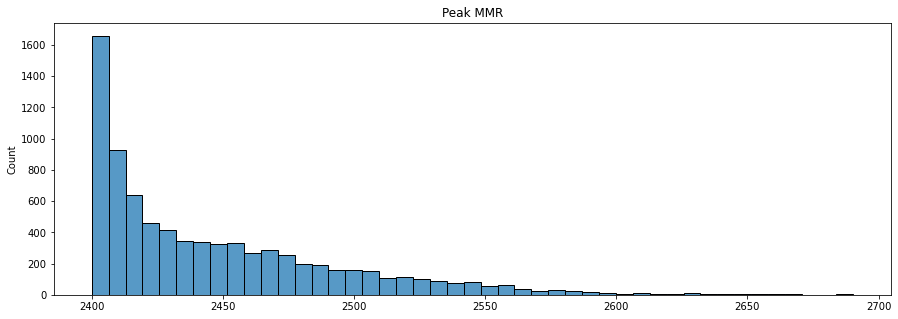

<IPython.core.display.Javascript object>

In [10]:
sns.histplot([agent.peak_mmr for agent in model.schedule.agents]).set_title("Peak MMR")
plt.show()

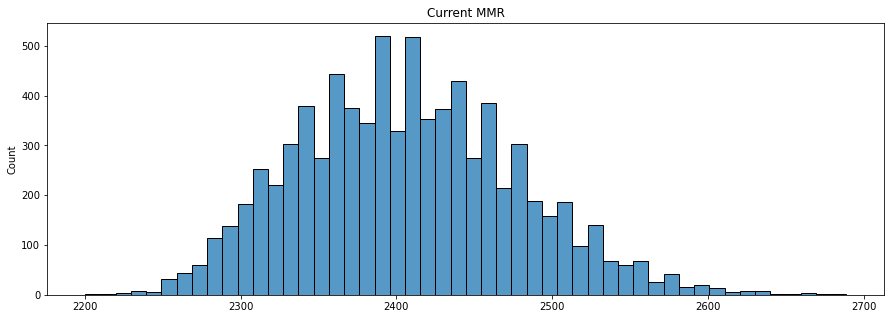

<IPython.core.display.Javascript object>

In [11]:
sns.histplot([agent.current_mmr for agent in model.schedule.agents]).set_title(
    "Current MMR"
)
plt.show()

In [12]:
df = pd.DataFrame(
    {
        "player": [f"Player {agent.unique_id}" for agent in model.schedule.agents],
        "elo": [agent.elo_level for agent in model.schedule.agents],
        "playrate": [agent.playrate for agent in model.schedule.agents],
        "games played": [agent.games_played for agent in model.schedule.agents],
        "current MMR": [agent.current_mmr for agent in model.schedule.agents],
        "peak MMR": [agent.peak_mmr for agent in model.schedule.agents],
        "win rate": [agent.win_rate for agent in model.schedule.agents],
    }
)
df["rank"] = df["peak MMR"].rank(ascending=False)
df["elo bin"] = pd.cut(df["elo"], list(range(1100, 2800, 200)))
df["games played percentile"] = df["games played"].rank(pct=True)
df["games played bin"] = pd.cut(df["games played percentile"], [0, 0.25, 0.50, 0.75, 1])
df.to_excel(f"./data/final_data_experience_factor_{experience_factor}.xlsx")
df

,player,elo,playrate,games played,current MMR,peak MMR,win rate,rank,elo bin,games played percentile,games played bin
0,Player 0,1341.285714,14,121,2386.982421,2420.225972,48.760331,4739.0,"(1300, 1500]",0.751625,"(0.75, 1.0]"
1,Player 1,1656.714286,10,106,2421.959187,2446.266885,50.943396,3161.0,"(1500, 1700]",0.597750,"(0.5, 0.75]"
2,Player 2,1625.571429,15,113,2427.813249,2453.112232,51.327434,2834.0,"(1500, 1700]",0.669562,"(0.5, 0.75]"
3,Player 3,1329.285714,1,32,2305.889656,2400.000000,28.125000,7484.5,"(1300, 1500]",0.003375,"(0.0, 0.25]"
4,Player 4,1718.714286,11,118,2435.185517,2469.179943,51.694915,2108.0,"(1700, 1900]",0.720625,"(0.5, 0.75]"
...,...,...,...,...,...,...,...,...,...,...,...
7995,Player 7995,1379.285714,19,134,2394.109722,2424.654220,49.253731,4383.0,"(1300, 1500]",0.885625,"(0.75, 1.0]"
7996,Player 7996,1197.000000,4,56,2291.925445,2413.861827,35.714286,5319.0,"(1100, 1300]",0.114187,"(0.0, 0.25]"
7997,Player 7997,1277.142857,16,119,2387.084787,2402.358244,48.739496,6457.0,"(1100, 1300]",0.730563,"(0.5, 0.75]"
7998,Player 7998,1241.142857,5,61,2316.027517,2400.000000,39.344262,7484.5,"(1100, 1300]",0.159375,"(0.0, 0.25]"


<IPython.core.display.Javascript object>

In [31]:
# experience_factor = 0
# df = pd.read_excel(f"./data/final_data_experience_factor_{experience_factor}.xlsx").drop(
#     columns=["Unnamed: 0"]
# )
# df = df.sort_values(["elo bin", "games played bin"])
# df

,player,elo,playrate,games played,current MMR,peak MMR,win rate,rank,elo bin,games played percentile,games played bin
1,Player 1,1284.142857,4,65,2344.332458,2408.421244,43.076923,5784.0,"(1100, 1300]",0.179063,"(0.0, 0.25]"
2,Player 2,1299.142857,7,71,2357.819543,2400.000000,45.070423,7552.0,"(1100, 1300]",0.243312,"(0.0, 0.25]"
40,Player 40,1238.142857,5,69,2329.815980,2406.859099,42.028986,6435.5,"(1100, 1300]",0.221438,"(0.0, 0.25]"
49,Player 49,1291.142857,4,60,2363.915782,2400.000000,45.000000,7552.0,"(1100, 1300]",0.128125,"(0.0, 0.25]"
102,Player 102,1212.142857,2,48,2349.541087,2413.726378,41.666667,5478.0,"(1100, 1300]",0.028250,"(0.0, 0.25]"
...,...,...,...,...,...,...,...,...,...,...,...
6289,Player 6289,2667.000000,18,139,2585.247562,2623.316703,59.712230,16.0,"(2500, 2700]",0.957438,"(0.75, 1.0]"
7196,Player 7196,2547.857143,18,130,2571.713937,2578.698543,59.230769,81.0,"(2500, 2700]",0.876062,"(0.75, 1.0]"
7523,Player 7523,2555.857143,12,120,2573.058829,2573.058829,60.000000,100.0,"(2500, 2700]",0.778188,"(0.75, 1.0]"
7604,Player 7604,2649.000000,17,134,2626.069166,2640.740116,61.940299,8.0,"(2500, 2700]",0.915875,"(0.75, 1.0]"


<IPython.core.display.Javascript object>

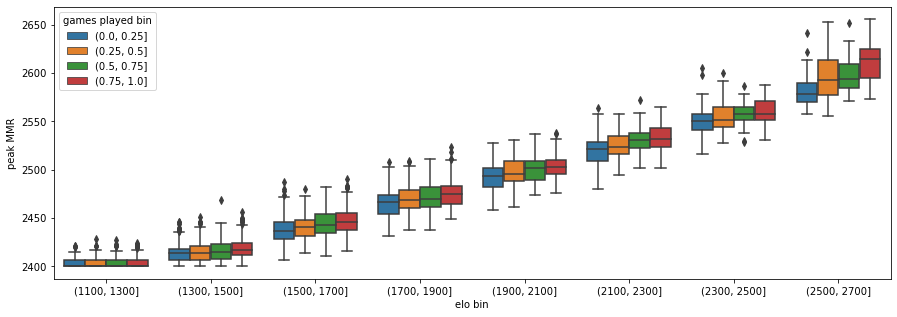

<IPython.core.display.Javascript object>

In [32]:
sns.boxplot(
    x="elo bin", y="peak MMR", hue="games played bin", data=df,
)
plt.savefig(f"./images/elo_vs_peakMMR_experience_factor_{experience_factor}.png")
plt.savefig(f"./images/elo_vs_peakMMR_experience_factor_{experience_factor}.svg")
plt.show()

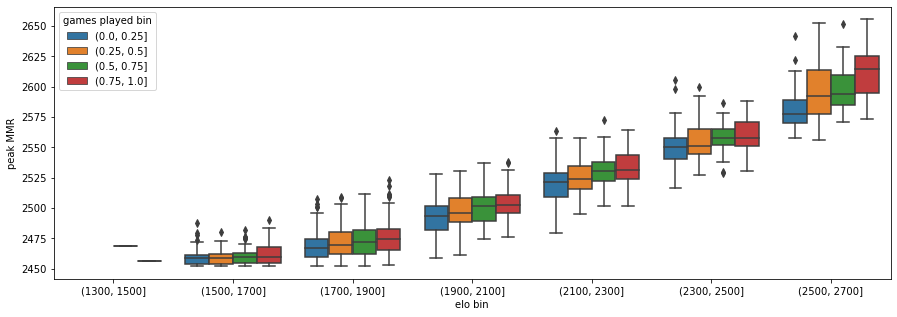

<IPython.core.display.Javascript object>

In [42]:
sns.boxplot(
    x="elo bin",
    y="peak MMR",
    hue="games played bin",
    data=df[df["rank"] < 2860],
    hue_order=sorted(set(df["games played bin"])),
)
plt.savefig(f"./images/elo_vs_peakMMR_experience_factor_{experience_factor}_top_2860.png")
plt.savefig(f"./images/elo_vs_peakMMR_experience_factor_{experience_factor}_top_2860.svg")
plt.show()

In [48]:
df.groupby("elo bin").agg(count=pd.NamedAgg("player", "count"))


,count
elo bin,
"(1100, 1300]",1788
"(1300, 1500]",2022
"(1500, 1700]",1664
"(1700, 1900]",1139
"(1900, 2100]",730
"(2100, 2300]",387
"(2300, 2500]",170
"(2500, 2700]",100


<IPython.core.display.Javascript object>

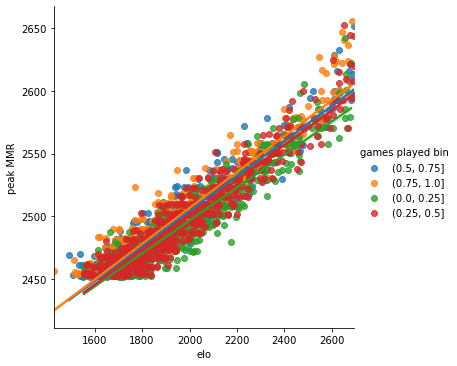

<IPython.core.display.Javascript object>

In [49]:
sns.lmplot(x="elo", y="peak MMR", hue="games played bin", data=df[df["rank"] < 2860])
plt.show()

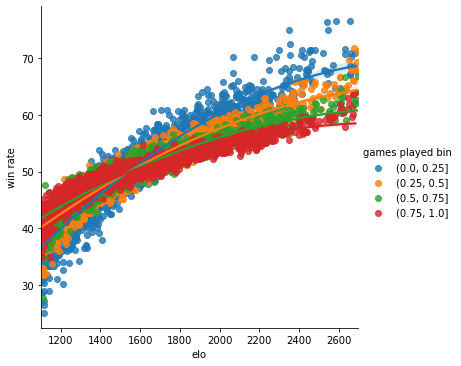

<IPython.core.display.Javascript object>

In [38]:
sns.lmplot(x="elo", y="win rate", hue="games played bin", data=df, order=2)
plt.show()

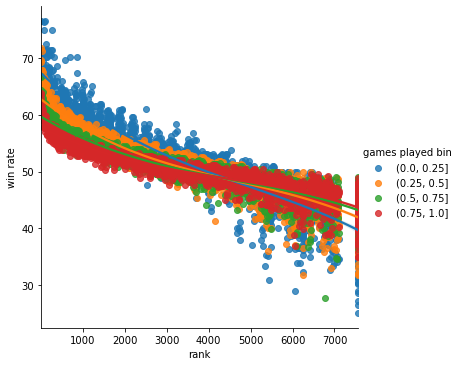

<IPython.core.display.Javascript object>

In [37]:
sns.lmplot(x="rank", y="win rate", hue="games played bin", data=df, order=3)
plt.show()